In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(data_dir)

/aiffel/aiffel/kaggle/data


In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형으로 전처리
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
del train['id'] # id삭제

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int) # test에도 똑같이적용

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

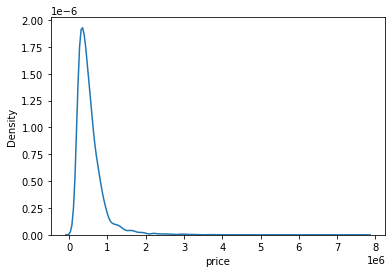

In [9]:
sns.kdeplot(y)
plt.show()

In [10]:
y = np.log1p(y) # 왼쪽으로 치우쳐져있는 price를 로그변환으로 완만하게 만들어줌
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

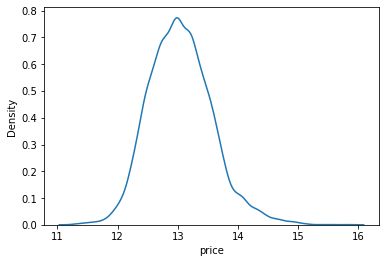

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info() # 정수자료형 변환 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
# RMSE 계산

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [14]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [15]:
random_state=2020        # 고정값 지정 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [16]:
gboost.__class__.__name__ # 모델이름확인

'GradientBoostingRegressor'

In [17]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [18]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [70, 200],
    'max_depth': [20, 200],
}

In [20]:
model = LGBMRegressor(random_state=random_state)

In [21]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [20, 200], 'n_estimators': [70, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [22]:
grid_model.cv_results_

{'mean_fit_time': array([0.58731446, 0.88880668, 0.60093684, 0.93434067]),
 'std_fit_time': array([0.1378544 , 0.01585141, 0.16614776, 0.08744921]),
 'mean_score_time': array([0.03184447, 0.07205219, 0.03927894, 0.05870047]),
 'std_score_time': array([0.01605057, 0.00966515, 0.01697899, 0.0133821 ]),
 'param_max_depth': masked_array(data=[20, 20, 200, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[70, 200, 70, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 20, 'n_estimators': 70},
  {'max_depth': 20, 'n_estimators': 200},
  {'max_depth': 200, 'n_estimators': 70},
  {'max_depth': 200, 'n_estimators': 200}],
 'split0_test_score': array([-0.0274302 , -0.02610891, -0.0274302 , -0.02610891]),
 'split1_test_score': array([-0.02879316, -0.02721547, -0.02879316, -0.02721547]),
 'split2_test_score': array([-0.

In [23]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 20, 'n_estimators': 70},
 {'max_depth': 20, 'n_estimators': 200},
 {'max_depth': 200, 'n_estimators': 70},
 {'max_depth': 200, 'n_estimators': 200}]

In [24]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02784765, -0.02624485, -0.02784765, -0.02624485])

In [25]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,20,70,-0.027848
1,20,200,-0.026245
2,200,70,-0.027848
3,200,200,-0.026245


In [26]:
results['RMSE'] = np.sqrt(-1 * results['score']) # RMSE 추가
results

,max_depth,n_estimators,score,RMSE
0,20,70,-0.027848,0.166876
1,20,200,-0.026245,0.162003
2,200,70,-0.027848,0.166876
3,200,200,-0.026245,0.162003


In [27]:
results = results.rename(columns={'RMSE': 'RMSLE'}) # Root Mean Squared Log Error로 이름변경
results

,max_depth,n_estimators,score,RMSLE
0,20,70,-0.027848,0.166876
1,20,200,-0.026245,0.162003
2,200,70,-0.027848,0.166876
3,200,200,-0.026245,0.162003


In [28]:
results = results.sort_values('RMSLE') # sort_values 로 낮은순서대로 정렬
results

,max_depth,n_estimators,score,RMSLE
1,20,200,-0.026245,0.162003
3,200,200,-0.026245,0.162003
0,20,70,-0.027848,0.166876
2,200,70,-0.027848,0.166876


In [29]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [30]:
# 그리드 탐색
param_grid = {
    'n_estimators': [70, 200],
    'max_depth': [20, 200],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
1,20,200,-0.026245,0.162003
3,200,200,-0.026245,0.162003
0,20,70,-0.027848,0.166876
2,200,70,-0.027848,0.166876


In [31]:
model = LGBMRegressor(max_depth=200, n_estimators=200, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.10925691, 13.09696202, 14.14774759, ..., 13.02723041,
       12.68215912, 13.00123696])

In [32]:
prediction = np.expm1(prediction)
prediction

array([ 493488.52522109,  487458.26986304, 1394082.25493781, ...,
        454625.01339841,  321951.44129481,  442959.9772121 ])

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.934885e+05
1,15036,4.874583e+05
2,15037,1.394082e+06
3,15038,3.109311e+05
4,15039,3.336768e+05


In [35]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle/data/submission_lgbm_RMSLE_0.164399.csv


In [36]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [37]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle/data/submission_lgbm_RMSLE_0.0168.csv saved!


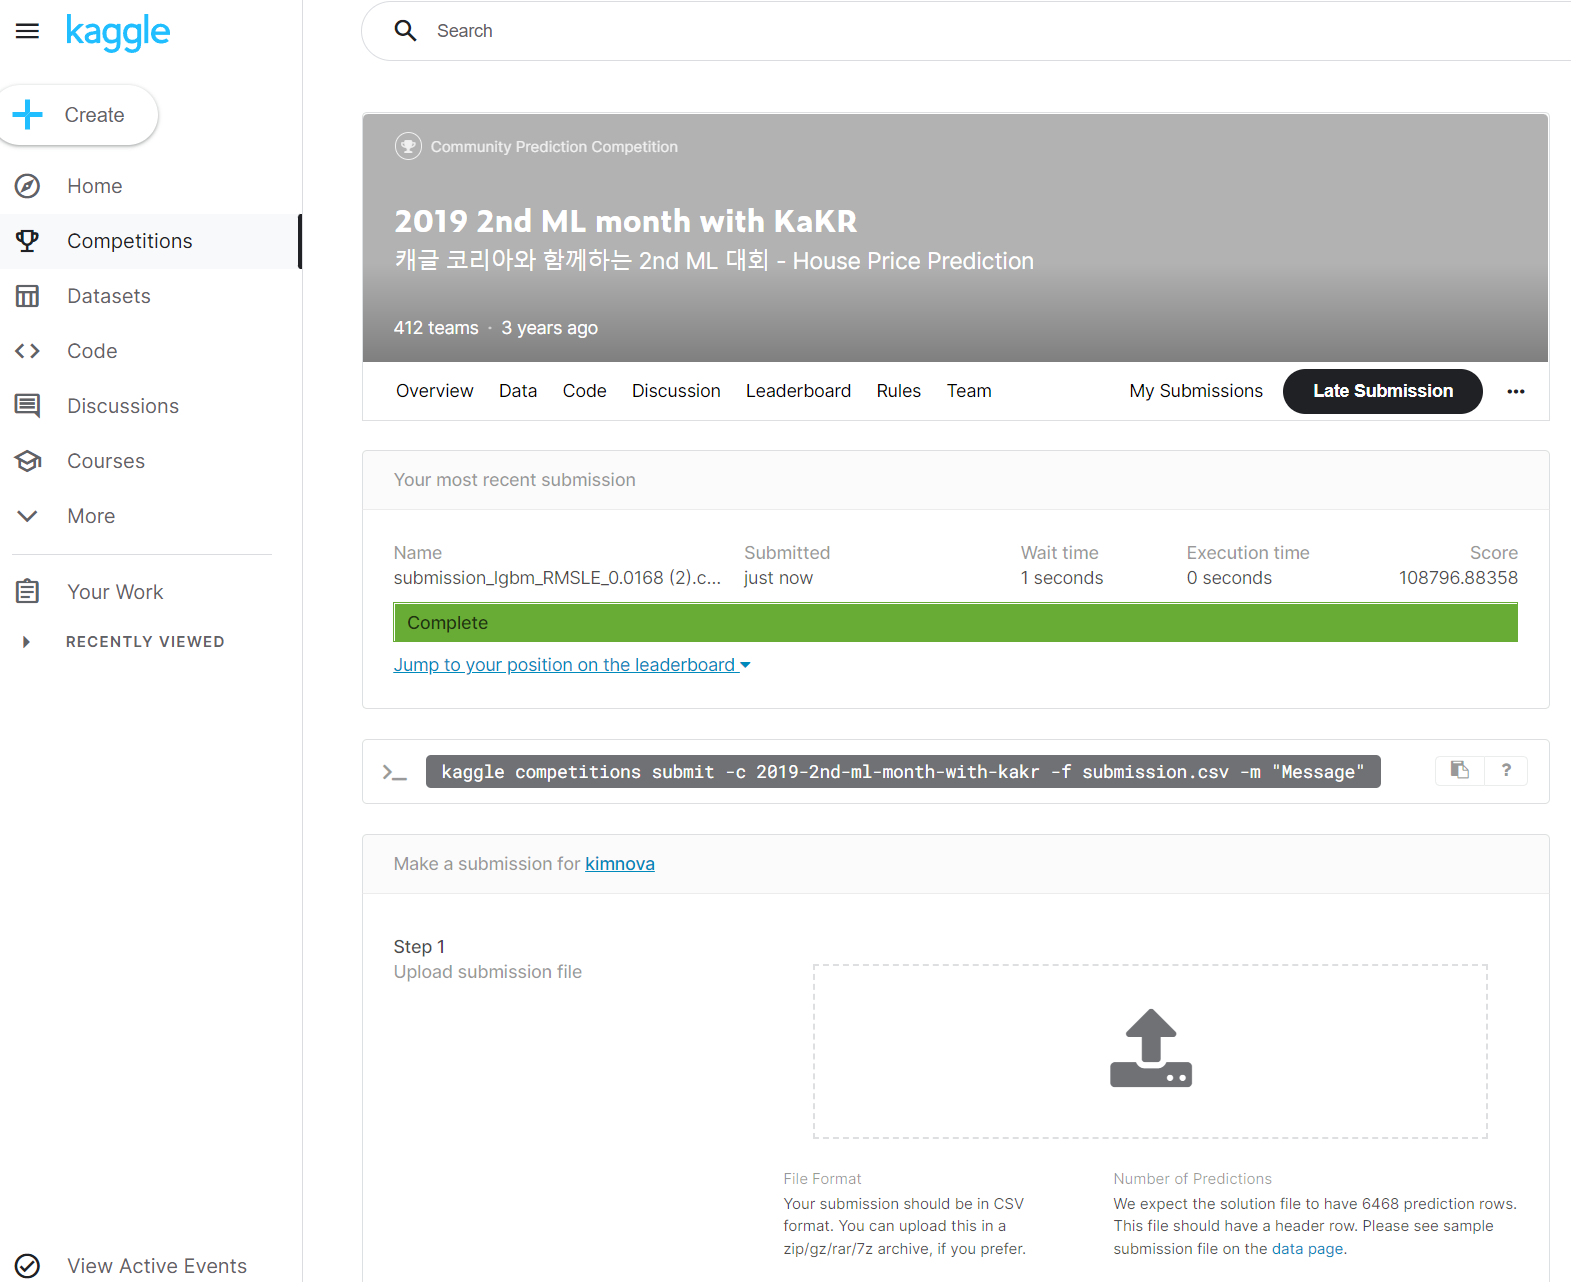

In [40]:
from PIL import Image
img = os.getenv('HOME')+'/aiffel/kaggle/data/score.PNG'
im = Image.open(img)
im

In [41]:
print('최종스코어: 108796')

최종스코어: 108796
[CV] END ......................max_depth=20, n_estimators=70; total time=   0.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=200, n_estimators=70; total time=   0.5s
[CV] END ....................max_depth=200, n_estimators=200; total time=   1.0s
[CV] END ......................max_depth=20, n_estimators=70; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.4s
[CV] END .....................max_depth=200, n_estimators=70; total time=   0.5s
[CV] END ....................max_depth=200, n_estimators=200; total time=   0.9s
[CV] END ......................max_depth=20, n_estimators=70; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=200, n_estimators=70; total time=   0.4s
[CV] END .....................max_depth=200, n_estimators=70; total time=   0.7s
[CV] END .....